In [319]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import acquire_r
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import logistic_regression_util
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [97]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [315]:
# List of urls to scrape
g_url = ['https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=forks&type=Repositories', ' https://github.com/search?o=desc&p=2&q=stars%3A%3E1&s=forks&type=Repositories'\
         'https://github.com/search?o=desc&p=3&q=stars%3A%3E1&s=forks&type=Repositories', 'https://github.com/search?o=desc&p=4&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=5&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=6&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=7&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=8&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=9&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=10&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=11&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=12&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=13&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=14&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=15&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=16&q=stars%3A%3E1&s=forks&type=Repositories',
        'https://github.com/search?o=desc&p=17&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=18&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=19&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=20&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=21&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=22&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=23&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=24&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=25&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=26&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=27&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=28&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=29&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=30&q=stars%3A%3E1&s=forks&type=Repositories']

In [316]:
def get_repos(urls):
    repo = []
    for url in urls:
        time.sleep(10)
        response = get(url, headers=headers)
        soup = BeautifulSoup(response.text)
        text = soup.find_all(attrs={"f4 text-normal"})
        for i in text:
            repo.append(i.find('a')['href'])
    return repo

In [317]:
repos = get_repos(g_url)

In [323]:
# list = []
# for repo in repos:
#     list.append(repo[1:])
#repos = scraper.get_repos(g_url)    

In [95]:
f = open('data2.json')
json_file = json.load(f)

In [96]:
df = pd.DataFrame(json_file)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             280 non-null    object
 1   language         245 non-null    object
 2   readme_contents  280 non-null    object
dtypes: object(3)
memory usage: 6.7+ KB


In [98]:
df.isnull().sum()

repo                0
language           35
readme_contents     0
dtype: int64

In [99]:
df = df.dropna(axis =0)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 1 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             245 non-null    object
 1   language         245 non-null    object
 2   readme_contents  245 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


In [101]:
df = df.reset_index(drop = True)

In [102]:
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
HTML                12
Jupyter Notebook    12
Go                  11
PHP                 11
TypeScript          10
Ruby                 9
C                    8
CSS                  8
Shell                5
Vue                  3
Rust                 2
TeX                  2
C#                   2
PowerShell           2
R                    2
Kotlin               2
Scala                1
Objective-C          1
Swift                1
Groovy               1
ApacheConf           1
Dart                 1
Name: language, dtype: int64

In [103]:
df = df.groupby('language').filter(lambda x : len(x)>5)

In [104]:
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
Jupyter Notebook    12
HTML                12
PHP                 11
Go                  11
TypeScript          10
Ruby                 9
C                    8
CSS                  8
Name: language, dtype: int64

In [105]:
df['language'] = df.language.replace(['PHP','Shell','Kotlin','Vue','ApacheConf','Jupyter Notebook','R','Groovy',\
                                      'Kotlin','Scala','Rust', 'Swift','C#','Dart','Ruby','Objective-C','PowerShell','TeX',\
                                     'C', 'CSS', 'TypeScript', 'Go'], 'Other')

In [106]:
df.language.value_counts()

Other         69
JavaScript    58
Java          33
Python        31
C++           16
HTML          12
Name: language, dtype: int64

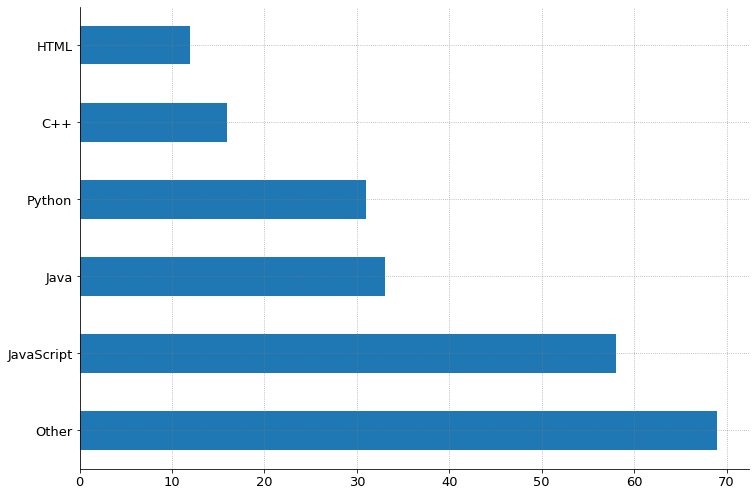

In [107]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh()

In [108]:
df = df.drop(columns = ['repo'])

In [109]:
df.head(4)

,language,readme_contents
1,HTML,### Well hello there!\n\nThis repository is me...
2,C++,"<div align=""center"">\n <img src=""https://www...."
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
5,Python,![Logo](https://storage.googleapis.com/model_g...


In [110]:
df = prepare_r.prep_contents(df)

In [111]:
df.head(4)

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
1,HTML,### Well hello there!\n\nThis repository is me...,### Well hello there!\n\nThis repository is me...,well hello there this repository meant pro...,well hello there thi repositori meant provid e...,well hello there this repository meant provide...,well hello repository meant provide example fo...
2,C++,"<div align=""center"">\n <img src=""https://www....","<div align=""center"">\n <img src=""https://www....",div align center img src https www te...,div align center img src http www tensorflow o...,div align center img src http www tensorflow o...,div align center img src tensorflow org image ...
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...","<p align=""center"">\n <a href=""https://getboot...",align center href https getbootstrap...,align center href http getbootstrap com img sr...,align center href http getbootstrap com img sr...,align center href getbootstrap com img src get...
5,Python,![Logo](https://storage.googleapis.com/model_g...,![Logo](https://storage.googleapis.com/model_g...,logo https storage googleapis com model gar...,logo http storag googleapi com model garden ar...,logo http storage googleapis com model garden ...,logo storage googleapis com model garden artif...


In [112]:
df = df.drop(columns = ['original', 'stemmed', 'normalized', 'lemmatized'])
df.head(4)

,language,readme_contents,cleaned
1,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...
2,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src tensorflow org image ...
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...
5,Python,![Logo](https://storage.googleapis.com/model_g...,logo storage googleapis com model garden artif...


In [113]:
df = df.reset_index()

In [114]:
# Train/test split before exploration
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

## Exploration
***

In [115]:
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com        9172
org        1773
img        1149
doc        1116
python     1088
master     1000
svg         988
code        952
api         941
src         917
use         882
file        877
html        857
library     851
data        821
dtype: int64

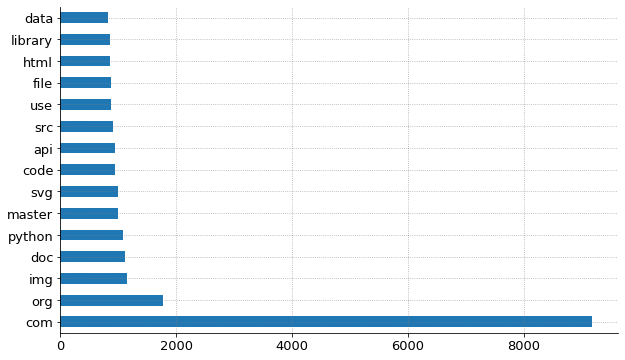

In [116]:
plt.figure(figsize = (10,6))
word_counts.plot.barh()

In [117]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in train.cleaned if word in doc])
    return len(train.cleaned) / n_occurences

In [118]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['python', 'server', 'com', ..., 'happyholidaysto',
       'happycustomholidayto', 'holidaycountdown'], dtype=object)

In [119]:
# make a data frame for unique words
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

In [120]:
idf_train.head(10)

,idf
word,
holidaycountdown,175.0
myapps,175.0
gurkankaymak,175.0
launching,175.0
ahoy,175.0
wordmark,175.0
hocon,175.0
hjson,175.0
intuitcom,175.0


Text(0.5, 0, 'IDF value')

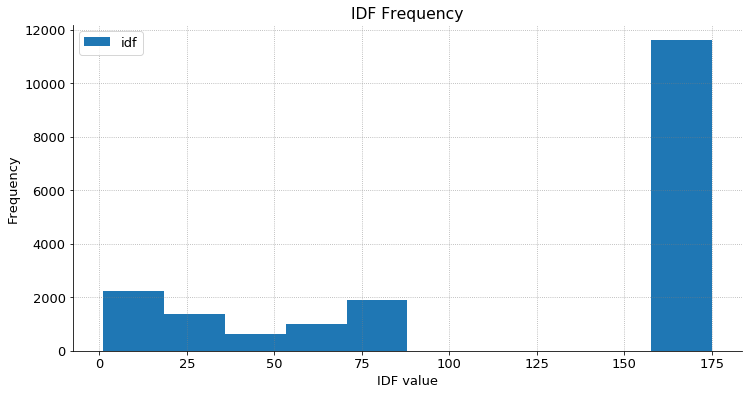

In [121]:
idf_train.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')


In [122]:
# here we create a new column with number of words for each readme file.
train['readme_words'] = train['cleaned'].apply(lambda x: len(x.split()))

(0, 10000)

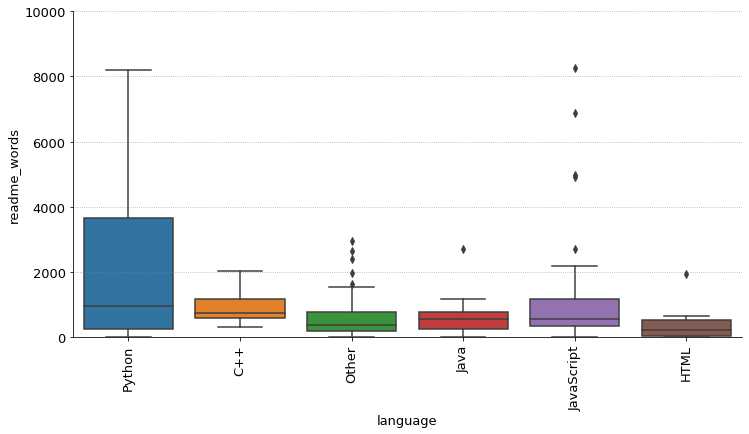

In [123]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,10000)

(0, 5000)

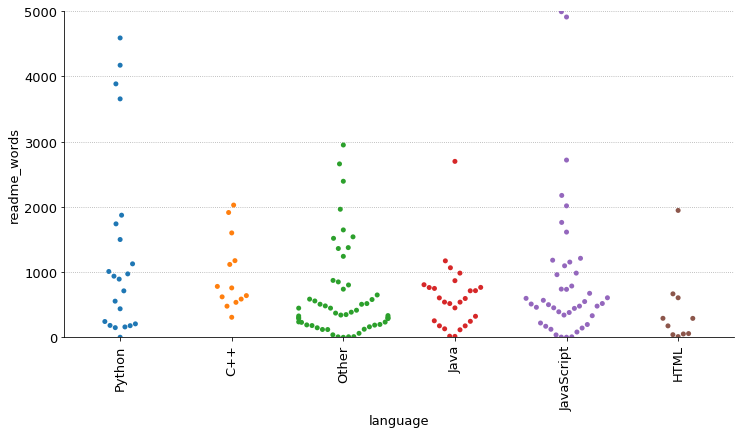

In [124]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,5000)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread

In [125]:
All_words = pd.Series(' '.join(train.cleaned).split()).value_counts()
JavaScript_words = pd.Series(' '.join(train[train.language == 'JavaScript'].cleaned).split()).value_counts()
Other_words = pd.Series(' '.join(train[train.language == 'Other'].cleaned).split()).value_counts()
Python_words = pd.Series(' '.join(train[train.language == 'Python'].cleaned).split()).value_counts()
java_words = pd.Series(' '.join(train[train.language == 'Java'].cleaned).split()).value_counts()
TypeScript_words = pd.Series(' '.join(train[train.language == 'TypeScript'].cleaned).split()).value_counts()
Cplus_words = pd.Series(' '.join(train[train.language == 'C++'].cleaned).split()).value_counts()
CSS_words = pd.Series(' '.join(train[train.language == 'CSS'].cleaned).split()).value_counts()
HTML_words = pd.Series(' '.join(train[train.language == 'HTML'].cleaned).split()).value_counts()
C_words = pd.Series(' '.join(train[train.language == 'C'].cleaned).split()).value_counts()
Go_words = pd.Series(' '.join(train[train.language == 'Go'].cleaned).split()).value_counts()

In [126]:
word_counts = (pd.concat([All_words, JavaScript_words, Other_words, Python_words,java_words, TypeScript_words, Cplus_words,\
                         CSS_words,HTML_words, C_words, Go_words],\
                         axis=1, sort=True).set_axis(['All','JavaScript', 'Other', 'Python','Java', 'TypeScript', 'C++',\
                         'CSS','HTML', 'C', 'Go_'], axis=1, inplace=False).fillna(0)\
               .apply(lambda s: s.astype(int)))

word_counts.head()

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
aaaaaaaaaac,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaaai,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaad,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaecm,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaerc,1,1,0,0,0,0,0,0,0,0,0


In [127]:
word_counts.sort_values(by='All', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,9172,2093,3264,2627,582,0,480,0,126,0,0
org,1773,492,350,493,131,0,280,0,27,0,0
img,1149,681,157,136,127,0,39,0,9,0,0
doc,1116,307,173,297,231,0,95,0,13,0,0
python,1088,2,236,787,5,0,57,0,1,0,0
master,1000,185,387,198,90,0,134,0,6,0,0
svg,988,615,168,66,71,0,64,0,4,0,0
code,952,205,393,244,42,0,47,0,21,0,0
api,941,207,225,419,49,0,40,0,1,0,0
src,917,679,77,72,57,0,28,0,4,0,0


In [128]:
word_counts.sort_values(by='JavaScript', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,9172,2093,3264,2627,582,0,480,0,126,0,0
opencollective,768,713,14,1,14,0,26,0,0,0,0
webpack,733,713,20,0,0,0,0,0,0,0,0
img,1149,681,157,136,127,0,39,0,9,0,0
src,917,679,77,72,57,0,28,0,4,0,0
false,671,647,9,11,1,0,0,0,3,0,0
svg,988,615,168,66,71,0,64,0,4,0,0
javascript,718,613,26,8,2,0,9,0,60,0,0
href,749,534,69,89,38,0,14,0,5,0,0
requireactive,524,524,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Word cloud for all words')

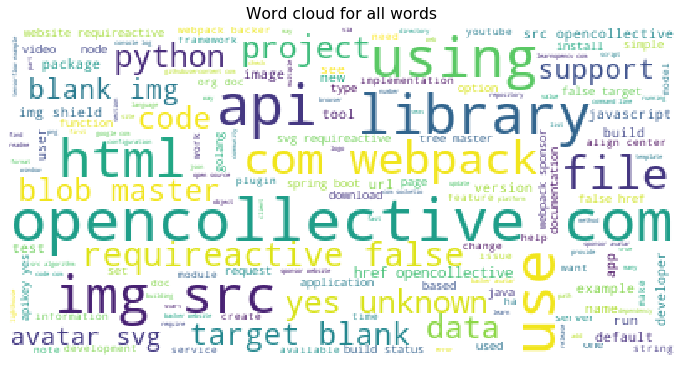

In [129]:
# word cloud for all words
img = WordCloud(background_color='white').generate(' '.join(train.cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Word cloud for all words')

Text(0.5, 1.0, 'Python wordcloud')

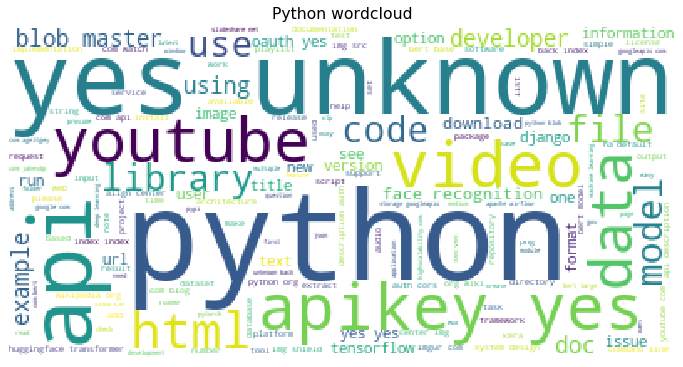

In [130]:
# word cloud for Python
img = WordCloud(background_color='white').generate(' '.join(train[train.language == 'Python'].cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python wordcloud')

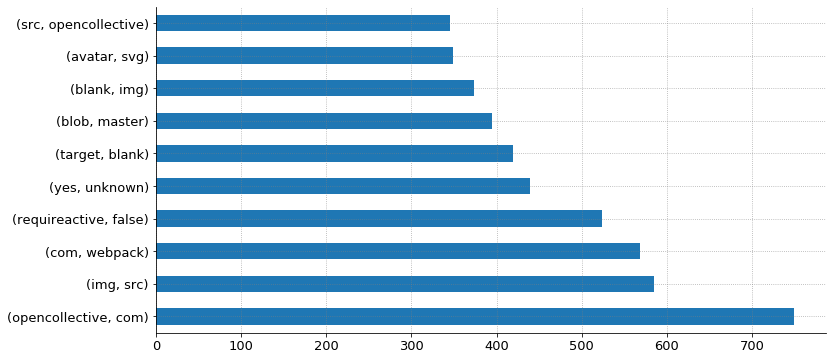

In [131]:
#lets look at bigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 2)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [132]:
top_30_bigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 2)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Bigrams')

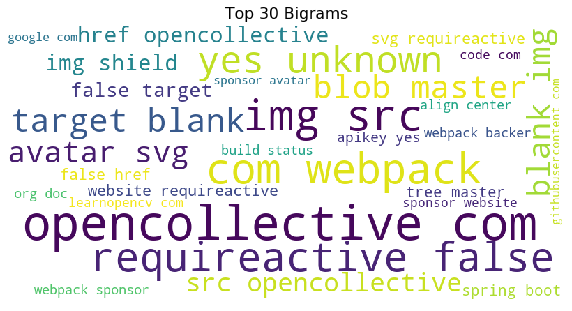

In [133]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Bigrams')

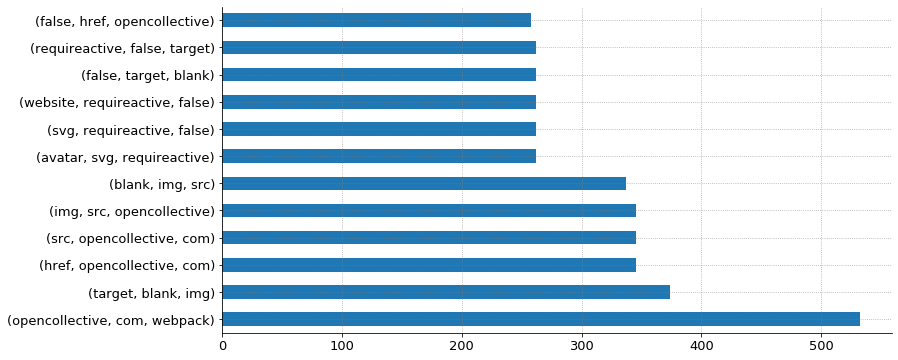

In [134]:
#lets look at trigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 3)
pd.Series(bigrams).value_counts().head(12).plot.barh()

In [135]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2),
                                    token_pattern=r'\b\w+\b', min_df=1)

In [136]:
X_2 = bigram_vectorizer.fit_transform(df.cleaned).toarray()

In [137]:
X_2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [138]:
top_30_trigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 3)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Trigrams')

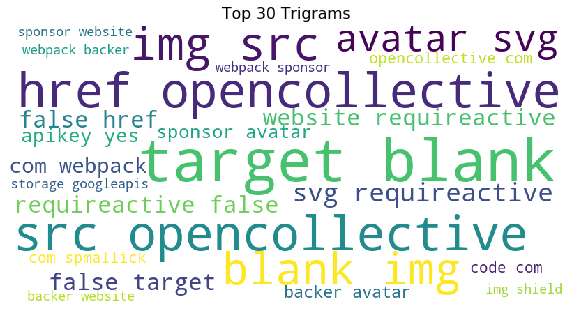

In [139]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Trigrams')

In [140]:
def digits(text):
    digits = len(re.findall(r'[0-9]', text ))
    return digits    

def link(text):
    link = len((re.findall(r'http', text )))
    return link

In [141]:
train['link'] = train.readme_contents.apply(link)

In [142]:
train['digits'] = train.readme_contents.apply(digits)

In [143]:
train.head(5)

,index,language,readme_contents,cleaned,readme_words,link,digits
113,132,Python,### 12306 购票小助手\n#### python版本\n - [ ] 2.7.10...,python server com zhaipro easy pan baidu com v...,161,15,312
3,5,Python,![Logo](https://storage.googleapis.com/model_g...,logo storage googleapis com model garden artif...,208,8,70
218,244,C++,# Tesseract OCR\n\n[![Build Status](https://tr...,tesseract ocr build status travis org tesserac...,782,55,118
63,71,Other,# Ionic\n\n[Ionic](https://ionicframework.com/...,ionic ionic ionicframework com open source mob...,290,22,17
12,14,Java,"# <img src=""src/docs/spring-framework.png"" wid...",img src src doc spring framework png width hei...,255,17,13


(0, 1000)

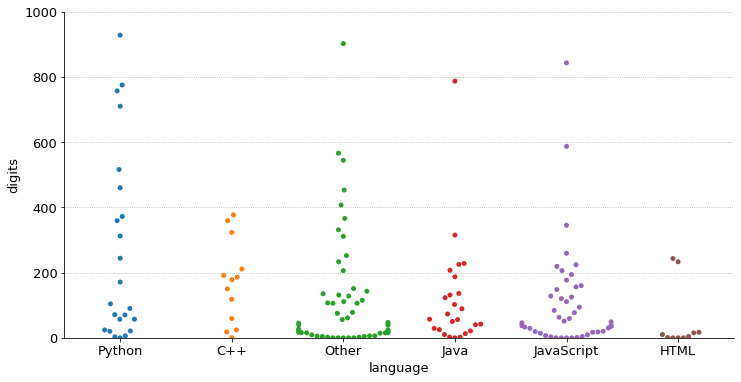

In [144]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'digits', data = train)
plt.ylim(0,1000)

(0, 200)

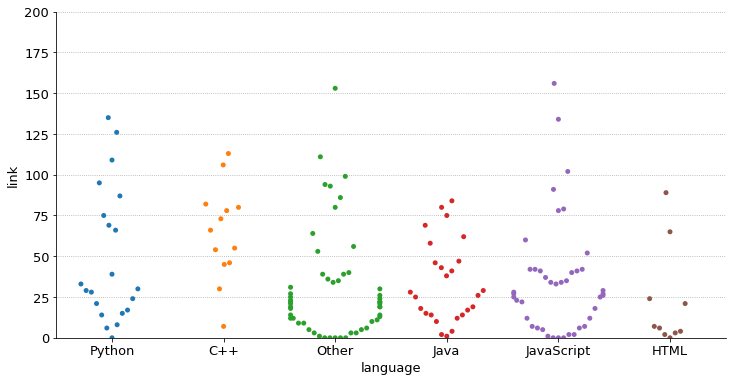

In [145]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'link', data = train)
plt.ylim(0,200)

In [146]:
def avg_word(sentence):
    
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

In [147]:
train['avg_word'] = train['cleaned'].apply(lambda x: avg_word(x))

(0, 20)

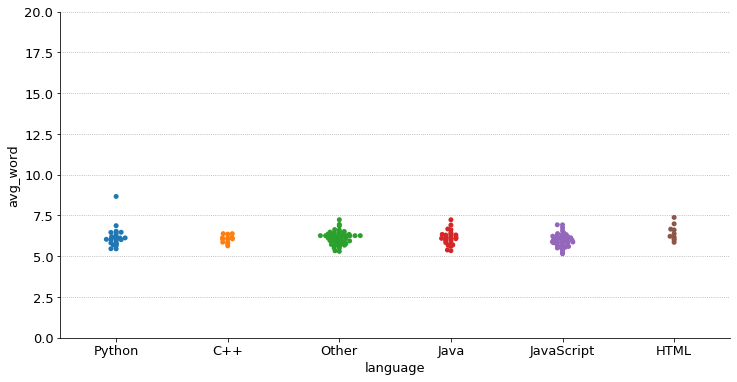

In [148]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'avg_word', data = train)
plt.ylim(0,20)

In [149]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['stopwords'] = train['readme_contents'].apply(lambda x: len([x for x in x.split() if x in stop]))


(0, 1000)

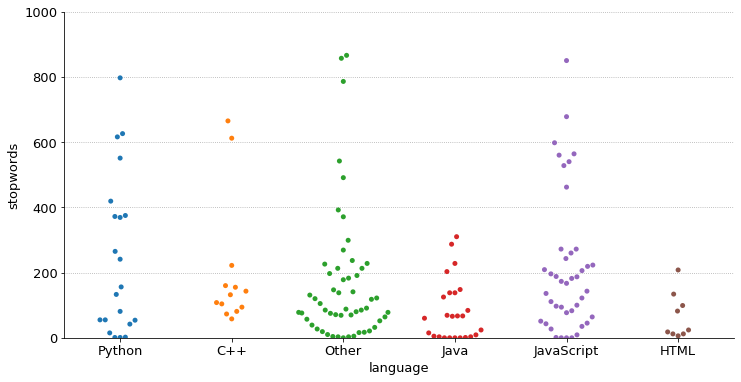

In [150]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'stopwords', data = train)
plt.ylim(0,1000)

## Modeling Using Bag of Words

In [190]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.cleaned)
y = df.language


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [192]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [193]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 54.29%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       1
Java          0     0    12           0      3       3
JavaScript    1     0     0          23      0       0
Other         4    10    14          23     52      21
---
              precision    recall  f1-score   support

         C++       0.89      0.62      0.73        13
        HTML       0.00      0.00      0.00        10
        Java       0.67      0.46      0.55        26
  JavaScript       0.96      0.50      0.66        46
       Other       0.42      0.95      0.58        55
      Python       0.00      0.00      0.00        25

    accuracy                           0.54       175
   macro avg       0.49      0.42      0.42       175
weighted avg       0.55      0.54      0.49       175



In [194]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 40.91%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           0     0     0           0      1       0
Java          0     0     2           1      0       1
JavaScript    1     0     0           3      0       0
Other         2     2     5           8     13       5
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.50      0.29      0.36         7
  JavaScript       0.75      0.25      0.38        12
       Other       0.37      0.93      0.53        14
      Python       0.00      0.00      0.00         6

    accuracy                           0.41        44
   macro avg       0.27      0.24      0.21        44
weighted avg       0.40      0.41      0.33        44



## Modeling

In [293]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [295]:
X_train

<175x21870 sparse matrix of type '<class 'numpy.float64'>'
	with 58816 stored elements in Compressed Sparse Row format>

In [296]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

#### Logistic Regression Model

In [297]:
logit = LogisticRegression(solver = 'liblinear', C = 10).fit(X_train, y_train)
train['predicted'] = logit.predict(X_train)
test['predicted'] = logit.predict(X_test)

In [298]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 100.00%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++          13     0     0           0      0       0
HTML          0    10     0           0      0       0
Java          0     0    26           0      0       0
JavaScript    0     0     0          46      0       0
Other         0     0     0           0     55       0
Python        0     0     0           0      0      25
---
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        13
        HTML       1.00      1.00      1.00        10
        Java       1.00      1.00      1.00        26
  JavaScript       1.00      1.00      1.00        46
       Other       1.00      1.00      1.00        55
      Python       1.00      1.00      1.00        25

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      

In [299]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 61.36%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          0     0     4           0      1       0
JavaScript    0     1     1           8      1       1
Other         3     1     2           4     12       2
Python        0     0     0           0      0       3
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.80      0.57      0.67         7
  JavaScript       0.67      0.67      0.67        12
       Other       0.50      0.86      0.63        14
      Python       1.00      0.50      0.67         6

    accuracy                           0.61        44
   macro avg       0.49      0.43      0.44        44
weighted avg       0.60      0.61      0.58        44



#### Decision Tree Classifier

In [300]:
from sklearn.tree import DecisionTreeClassifier
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [301]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.43%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       0
Java          0     2    16           0      0       0
JavaScript    1     0     0          32      5       0
Other         4     8    10          14     42       5
Python        0     0     0           0      8      20
---
              precision    recall  f1-score   support

         C++       1.00      0.62      0.76        13
        HTML       0.00      0.00      0.00        10
        Java       0.89      0.62      0.73        26
  JavaScript       0.84      0.70      0.76        46
       Other       0.51      0.76      0.61        55
      Python       0.71      0.80      0.75        25

    accuracy                           0.67       175
   macro avg       0.66      0.58      0.60       175
weighted avg       0.69      0.67      0.66       175



In [302]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 56.82%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          1     0     4           0      0       1
JavaScript    0     0     0           5      0       0
Other         2     2     3           6     13       2
Python        0     0     0           1      1       3
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.67      0.57      0.62         7
  JavaScript       1.00      0.42      0.59        12
       Other       0.46      0.93      0.62        14
      Python       0.60      0.50      0.55         6

    accuracy                           0.57        44
   macro avg       0.46      0.40      0.39        44
weighted avg       0.61      0.57      0.53        44



In [303]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)

In [304]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         C++       0.78      0.54      0.64        13
        HTML       0.33      0.10      0.15        10
        Java       0.84      0.81      0.82        26
  JavaScript       0.69      0.83      0.75        46
       Other       0.74      0.62      0.67        55
      Python       0.59      0.88      0.71        25

    accuracy                           0.70       175
   macro avg       0.66      0.63      0.62       175
weighted avg       0.70      0.70      0.69       175



In [305]:
y_pred_test = knn.predict(X_test)
y_pred_test

array(['Python', 'Java', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'Other', 'JavaScript', 'JavaScript', 'Other', 'Python', 'Other',
       'Other', 'Other', 'Java', 'Java', 'Other', 'Java', 'Other',
       'Python', 'JavaScript', 'Java', 'Other', 'Other', 'Python', 'HTML',
       'JavaScript', 'Python', 'HTML', 'Java', 'Python', 'Python',
       'JavaScript', 'Other', 'Other', 'Python', 'HTML', 'Python',
       'Python', 'Other', 'Python', 'Other', 'HTML', 'JavaScript'],
      dtype=object)

In [306]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.25      0.50      0.33         2
        Java       0.83      0.71      0.77         7
  JavaScript       0.75      0.50      0.60        12
       Other       0.54      0.50      0.52        14
      Python       0.23      0.50      0.32         6

    accuracy                           0.50        44
   macro avg       0.43      0.45      0.42        44
weighted avg       0.55      0.50      0.51        44



#### Random Forest Classifier

In [307]:
clf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=1000,
                            max_depth=5, 
                            random_state=42)

In [308]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [309]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.43%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       0
Java          0     2    16           0      0       0
JavaScript    1     0     0          32      5       0
Other         4     8    10          14     42       5
Python        0     0     0           0      8      20
---
              precision    recall  f1-score   support

         C++       1.00      0.62      0.76        13
        HTML       0.00      0.00      0.00        10
        Java       0.89      0.62      0.73        26
  JavaScript       0.84      0.70      0.76        46
       Other       0.51      0.76      0.61        55
      Python       0.71      0.80      0.75        25

    accuracy                           0.67       175
   macro avg       0.66      0.58      0.60       175
weighted avg       0.69      0.67      0.66       175



In [310]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 56.82%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          1     0     4           0      0       1
JavaScript    0     0     0           5      0       0
Other         2     2     3           6     13       2
Python        0     0     0           1      1       3
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.67      0.57      0.62         7
  JavaScript       1.00      0.42      0.59        12
       Other       0.46      0.93      0.62        14
      Python       0.60      0.50      0.55         6

    accuracy                           0.57        44
   macro avg       0.46      0.40      0.39        44
weighted avg       0.61      0.57      0.53        44



#### MLPClassifier

In [311]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1,
                     hidden_layer_sizes=(70,), random_state=123)

clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(70,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=123, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [312]:
clf.predict(X_train)

array(['Python', 'Python', 'C++', 'Other', 'Java', 'Java', 'Java',
       'Python', 'Java', 'JavaScript', 'Other', 'Other', 'Python', 'C++',
       'JavaScript', 'C++', 'Java', 'Other', 'Python', 'Java',
       'JavaScript', 'Other', 'Other', 'Python', 'Other', 'Other',
       'JavaScript', 'Java', 'Python', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'HTML', 'Java', 'JavaScript', 'JavaScript', 'Other',
       'HTML', 'Python', 'Java', 'Python', 'JavaScript', 'Other', 'HTML',
       'JavaScript', 'JavaScript', 'Java', 'Java', 'Java', 'JavaScript',
       'JavaScript', 'Other', 'Other', 'Java', 'Python', 'JavaScript',
       'Other', 'Python', 'Other', 'JavaScript', 'HTML', 'Other', 'Java',
       'Other', 'C++', 'JavaScript', 'C++', 'Other', 'Other',
       'JavaScript', 'JavaScript', 'JavaScript', 'Other', 'Other', 'Java',
       'Other', 'C++', 'Other', 'Python', 'Other', 'Python', 'Other',
       'Other', 'Other', 'C++', 'Other', 'Other', 'JavaScript', 'Java',
       'HTM

In [313]:
clf.score(X_train, y_train)

1.0

In [246]:
clf.score(X_test, y_test)

0.6136363636363636

### Naive Bayes Multinomial Classifier

In [347]:
clf = MultinomialNB(alpha = 0.1)
clf.fit(X, y)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [348]:
clf.predict(X_train)

array(['Python', 'Python', 'C++', 'Other', 'Java', 'Java', 'Java',
       'Python', 'Java', 'JavaScript', 'Other', 'Other', 'Python',
       'Other', 'JavaScript', 'C++', 'Java', 'Other', 'Python', 'Java',
       'JavaScript', 'Other', 'Other', 'Python', 'Other', 'Other',
       'JavaScript', 'Java', 'Python', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'HTML', 'Java', 'JavaScript', 'JavaScript', 'Other',
       'Other', 'Python', 'Java', 'Python', 'JavaScript', 'Other', 'HTML',
       'JavaScript', 'JavaScript', 'Other', 'Java', 'Java', 'JavaScript',
       'JavaScript', 'Other', 'Other', 'Java', 'Python', 'JavaScript',
       'Other', 'Python', 'Other', 'JavaScript', 'HTML', 'Other', 'Java',
       'Other', 'Other', 'JavaScript', 'C++', 'Other', 'Other',
       'JavaScript', 'JavaScript', 'JavaScript', 'Other', 'Other', 'Java',
       'Other', 'JavaScript', 'Other', 'Python', 'Other', 'Python',
       'Other', 'Other', 'Other', 'C++', 'Other', 'Other', 'JavaScript',
      

In [349]:
clf.score(X_train, y_train)

0.9371428571428572

In [350]:
clf.score(X_test, y_test)

0.9318181818181818

### Naive Bayes Bernoulli  Classifer

In [343]:
clf = BernoulliNB(alpha=1)
clf.fit(X_train, y_train)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [344]:
clf.predict(X_train)

array(['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other',
       'Python', 'Other', 'JavaScript', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other',
       'JavaScript', 'Other', 'Other', 'Python', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'Other', 'Other', 'Other', 'JavaScript', 'Other',
       'Other', 'Other', 'Other', 'Other', 'JavaScript', 'Other', 'Other',
       'JavaScript', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'JavaScript', 'Other', 'Other',
       'Other', 'JavaScript', 'Other', 'Other', 'Other', 'Other', 'Other',
       'JavaScript', 'Other', 'Other', 'Other', 'JavaScript',
       'JavaScript', 'JavaScript', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Python', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other', 'Java', 'Other',
       'Other'

In [345]:
clf.score(X_train, y_train)

0.52

In [346]:
clf.score(X_test, y_test)

0.3181818181818182